In [17]:
import numpy as np
import timeautoencoder as tae
import timediffusion_cond_label as ctdf
import DP as dp
import pandas as pd
import torch
import os
import time
import process_edited as pce
import random

In [14]:
filename = f'Data/nasdaq100_2019.csv'
# Read dataframe
print(filename)
real_df = pd.read_csv(filename)
real_df1 = real_df.drop('date', axis=1)

Data/nasdaq100_2019.csv


In [15]:
##################################################################################################################
# Pre-processing Data
threshold = 1; device = 'cuda'; column_to_partition = 'Symbol'
processed_data, time_info = dp.partition_multi_seq(real_df, threshold, column_to_partition);

In [16]:
##################################################################################################################
# Auto-encoder Training
n_epochs = 20000; eps = 1e-5
weight_decay = 1e-6 ; lr = 2e-4; hidden_size = 200; num_layers = 1; batch_size = 50
channels = 64; min_beta = 1e-5; max_beta = 0.1; emb_dim = 128; time_dim = 8
lat_dim = 7; seq_col = 'Symbol'
real_df1 = real_df1.drop(column_to_partition, axis=1)

ds = tae.train_autoencoder(real_df1, processed_data, channels, hidden_size, num_layers, lr, weight_decay, n_epochs, \
                           batch_size, threshold,  min_beta, max_beta, emb_dim, time_dim, lat_dim, device)

Output()

In [19]:
##################################################################################################################
# Diffusion Training
latent_features = ds[1];
hidden_dim = 250; num_layers = 2; diffusion_steps = 100; n_epochs = 20000; num_classes = len(latent_features)
diff = ctdf.train_diffusion(latent_features, time_info.to(device), hidden_dim, num_layers, diffusion_steps, n_epochs, num_classes)

  0%|          | 0/2 [00:00<?, ?it/s]

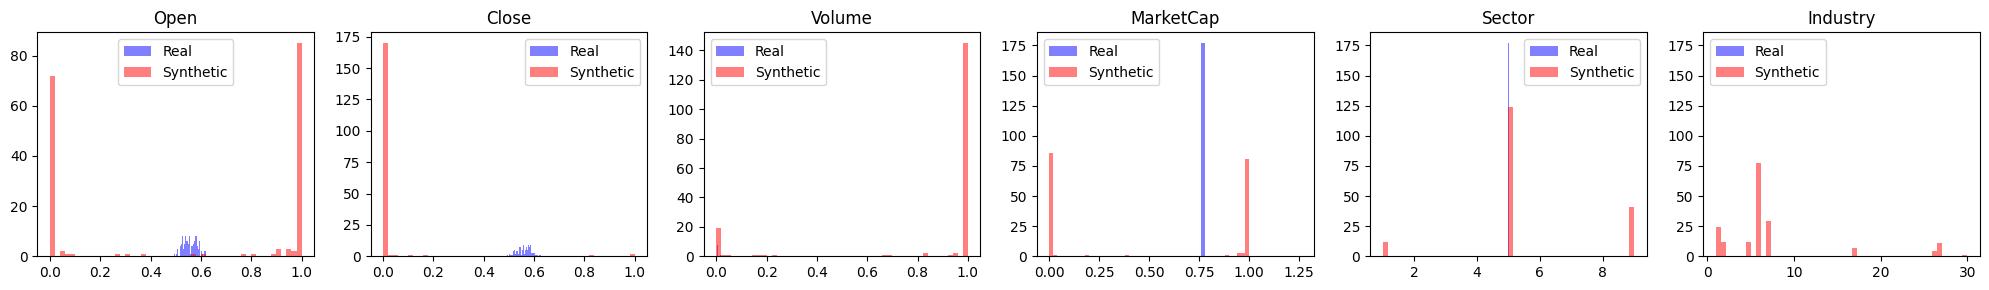

In [20]:
##################################################################################################################
# Sampling time-series tabular data of 8th entity 
N, T, _ = processed_data.shape; 

_, time_info = dp.partition_multi_seq(real_df, threshold, column_to_partition);

lbl = torch.arange(0, len(latent_features));  # Generate the entire Sequence  
label = torch.repeat_interleave(lbl, T, dim=0).reshape(len(lbl),T)

label=[8]; # 8th 
latent_features = latent_features[label,:,:]
time_info = time_info[label,:,:]

N, _, _ = latent_features.shape
t_grid = torch.linspace(0, 1, T).view(1, -1, 1).to(device) 

samples = ctdf.sample(t_grid.repeat(N, 1, 1), latent_features.detach().to(device), diff, time_info, label, cfg_scale = 3)

##################################################################################################################
# Post-process the generated data 
gen_output = ds[0].decoder(samples.to(device))  # Apply decoder to generated latent vector

data_size, seq_len, _ = latent_features.shape
synth_data = pce.convert_to_tensor(real_df1, gen_output, threshold, data_size, seq_len)
_synth_data = pce.convert_to_table(real_df1, synth_data, threshold)

In [ ]:
##################################################################################################################
# Draw the plots for marginal of featueres : Real v.s. Synthetic
_real_data = pce.convert_to_table(real_df1, processed_data[label,:,:], threshold)

# To see if you want to check real-data are recovered well.
B, L, K = _synth_data.shape

sd_reshaped = _synth_data.reshape(B * L, K)
pd_reshaped = _real_data.reshape(B * L, K)

import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=K, figsize=(20, 3))
column_names = real_df1.columns.tolist()

for k in range(0,K):
    title = column_names[k]
    
    axes[k].hist(pd_reshaped[:,k].cpu().detach(), bins=50, color='blue', alpha=0.5, label='Real')
    axes[k].hist(sd_reshaped[:,k].cpu().detach(), bins=50, color='red', alpha=0.5, label='Synthetic')
    
    # Move the legend line inside the with statement
    axes[k].legend()
    axes[k].set_title(title)

# Adjust layout to prevent overlapping titles
plt.tight_layout()
plt.savefig('nasdaq.png')
plt.show()